In [1]:
%load_ext autoreload
%load_ext autotime

time: 259 µs (started: 2023-10-08 21:03:53 -07:00)


In [2]:
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings('ignore')
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

time: 989 ms (started: 2023-10-08 21:03:53 -07:00)


In [3]:
import csv
import dask
import dask.dataframe as dd
import json
import numpy as np
import pandas as pd
print('pandas', pd.__version__)
print('dask', dask.__version__)
print('numpy', np.__version__)

pandas 1.5.3
dask 2022.12.1
numpy 1.21.0
time: 498 ms (started: 2023-10-08 21:03:54 -07:00)


In [4]:
%autoreload 2

from socket import gethostname
from wisio.cluster_management import ClusterConfig
from wisio.recorder import RecorderAnalyzer

n_workers = 8
trace_path = "/p/vast1/iopp/recorder_app_logs/genome_pegasus/nodes-32/_parquet"
working_dir = '.wisio/recorder/genome'
log_file = f"{working_dir}/worker_logs/%J.log"

analyzer = RecorderAnalyzer(
    checkpoint=False,
    checkpoint_dir=f"{trace_path}/_checkpoints13",
    cluster_config=ClusterConfig(
        cluster_type='lsf',
        dashboard_port=3616,
        header_skip=['-n', '-R', '-M', '-P', '-W 00:30'],
        host=gethostname(),
        job_extra=[
            '-nnodes 1', 
            '-G asccasc', 
            '-q pdebug', 
            '-W 120', 
            '-o {}'.format(log_file),
            '-e {}'.format(log_file),
        ],
        local_dir='/var/tmp/wisio-recorder-cm1',
        n_workers=n_workers,
        n_threads_per_worker=16,
        memory=n_workers * 200,
        use_stdin=True,
        verbose=True,
    ),
    working_dir=working_dir,
    debug=True,
)

analyzer

time: 1.13 s (started: 2023-10-08 21:03:55 -07:00)


In [5]:
analyzer.cluster_manager.client

Connection method: Cluster object,Cluster type: dask_jobqueue.LSFCluster
Dashboard: http://192.168.66.200:3616/status,
Dashboard: http://192.168.66.200:3616/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://192.168.66.200:42585,Workers: 0
Dashboard: http://192.168.66.200:3616/status,Total threads: 0
Started: Just now,Total memory: 0 B


time: 34.1 ms (started: 2023-10-08 21:03:56 -07:00)


In [6]:
from wisio._recorder.analysis import compute_high_level_metrics
from wisio._recorder.constants import VIEW_TYPES

global_min_max = analyzer.load_global_min_max(trace_path=trace_path)

hlm = compute_high_level_metrics(
    trace_path=trace_path,
    global_min_max=global_min_max,
    view_types=VIEW_TYPES,
)

hlm

computing hlm 2023-10-08 20:22:32.821974


,time_range,file_name,proc_name,io_cat,acc_pat,func_id,duration_sum,index_count,size_min,size_max,size_sum
npartitions=175,,,,,,,,,,,
,int64,object,object,uint64,uint64,object,float64,int64,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


time: 9min 6s (started: 2023-10-08 20:22:32 -07:00)


In [7]:
from dask.distributed import wait

_ = wait(hlm)

time: 9min 21s (started: 2023-10-08 20:31:42 -07:00)


In [8]:
hlm.npartitions

175

time: 3.09 ms (started: 2023-10-08 20:43:07 -07:00)


In [9]:
hlm.to_parquet('tmp/genome-hlm', compute=True, write_metadata_file=True)

time: 36.1 s (started: 2023-10-08 20:43:54 -07:00)


In [6]:
hlm = dd.read_parquet('tmp/genome-hlm')
hlm

,time_range,file_name,proc_name,io_cat,acc_pat,func_id,duration_sum,index_count,size_min,size_max,size_sum
npartitions=175,,,,,,,,,,,
,int64,object,object,uint64,uint64,object,float64,int64,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


time: 122 ms (started: 2023-10-08 21:04:43 -07:00)


In [7]:
import math
from wisio._recorder.analysis import EXTRA_COLS, _set_derived_columns, compute_main_view
from wisio._recorder.constants import VIEW_TYPES

# Set derived columns
hlm2 = _set_derived_columns(ddf=hlm)
# Compute agg_view
main_view = hlm2 \
    .drop(columns=EXTRA_COLS) \
    .groupby(VIEW_TYPES) \
    .sum(split_out=hlm.npartitions) \
    .repartition('256MB') \
    .persist()
# main_view = hlm2 \
#     .drop(columns=EXTRA_COLS) \
#     .groupby(VIEW_TYPES) \
#     .sum(split_out=math.ceil(math.sqrt(hlm.npartitions))) \
#     .persist()
# Set hashed ids
main_view['id'] = main_view.index.map(hash)

main_view

KilledWorker: Attempted to run task ('assign-567e3940f1032c33838d0b4ad5dead07', 79) on 3 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://192.168.64.33:37535. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

time: 3min 22s (started: 2023-10-08 21:04:48 -07:00)


In [11]:
_ = wait(main_view)

CancelledError: [('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 147), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 165), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 171), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 28), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 116), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 162), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 83), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 107), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 101), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 43), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 156), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 52), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 138), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 93), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 37), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 19), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 38), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 64), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 112), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 82), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 92), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 137), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 103), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 157), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 129), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 140), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 35), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 18), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 10), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 39), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 65), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 73), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 1), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 146), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 128), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 172), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 76), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 9), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 163), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 44), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 48), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 98), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 99), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 132), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 154), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 105), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 108), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 42), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 34), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 68), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 90), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 141), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 145), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 123), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 8), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 26), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 4), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 77), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 84), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 59), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 115), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 114), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 170), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 81), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 169), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 51), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 50), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 136), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 119), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 57), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 11), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 17), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 66), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 72), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 161), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 106), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 41), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 21), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 139), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 67), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 58), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 121), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 3), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 12), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 75), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 2), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 131), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 97), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 74), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 130), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 29), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 143), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 149), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 152), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 60), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 22), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 94), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 120), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 31), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 133), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 24), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 164), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 158), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 30), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 78), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 85), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 13), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 5), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 14), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 40), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 47), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 87), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 49), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 142), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 168), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 167), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 32), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 109), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 20), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 33), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 124), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 23), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 127), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 0), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 69), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 63), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 174), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 118), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 89), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 148), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 126), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 173), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 144), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 55), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 25), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 110), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 79), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 155), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 46), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 54), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 166), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 80), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 15), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 36), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 135), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 104), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 91), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 16), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 113), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 45), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 88), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 102), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 153), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 27), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 71), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 111), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 56), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 151), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 159), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 134), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 150), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 160), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 7), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 70), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 86), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 62), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 100), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 61), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 117), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 125), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 6), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 96), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 122), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 95), ('_groupby_aggregate-493ab7c23a64096a1bdcb4b9fede9b97', 53)]

time: 707 ms (started: 2023-10-08 20:49:06 -07:00)


In [6]:
%autoreload 2
# n_workers = 8
# no checkpoint
# main_view = ddf.npartitions > sqrt(ddf.npartitions)
# persist
# checkpoint
# group view = sqrt(ddf.npartitions)
# persist if parent view type
result = analyzer.analyze_parquet(
    trace_path=trace_path, 
    metrics=['duration'],
)

loading view _hlm 2023-10-08 18:50:13.036332
calling fallback for _hlm 2023-10-08 18:50:13.036460
computing hlm 2023-10-08 18:50:13.386624
storing view _hlm (175) 2023-10-08 18:58:36.434180
killing _hlm memory
loading stored _hlm 2023-10-08 19:08:03.512389
loading view _main_view 2023-10-08 19:08:03.558970
calling fallback for _main_view 2023-10-08 19:08:03.559014
storing view _main_view (175) 2023-10-08 19:08:04.315205


KilledWorker: Attempted to run task ('assign-d2813414736e1d51f2ecf478027c282b', 21) on 3 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://192.168.65.170:33171. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

time: 27min 35s (started: 2023-10-08 18:50:13 -07:00)


In [7]:
%autoreload 2
# n_workers = 8
# checkpointed
# main_view = ddf.npartitions > sqrt(ddf.npartitions)
# persist
# checkpoint
# group view = sqrt(ddf.npartitions)
# persist if parent view type
result = analyzer.analyze_parquet(
    trace_path=trace_path, 
    checkpoint=True,
    checkpoint_dir=f"{trace_path}/_checkpoints11",
    metrics=['duration'],
)

time: 47min 4s (started: 2023-09-28 12:08:51 -07:00)


In [9]:
result.main_view.memory_usage(deep=True).sum().compute()

15132117747

time: 2.52 s (started: 2023-09-28 13:29:14 -07:00)


In [10]:
15132117747 / 1024 ** 3

14.092882859520614

time: 2.54 ms (started: 2023-09-28 13:29:27 -07:00)


In [11]:
result.view_results['duration'][('proc_name',)].view.memory_usage(deep=True).sum().compute()

9407816105

time: 4.97 s (started: 2023-09-28 13:38:21 -07:00)


In [12]:
9407816105 / 1024 ** 3

8.761711516417563

time: 3.33 ms (started: 2023-09-28 13:38:36 -07:00)


In [ ]:
%autoreload 2
# n_workers = 8
# checkpointed
# main_view = ddf.npartitions > sqrt(ddf.npartitions)
# persist
# checkpoint
# group view = sqrt(ddf.npartitions)
# persist if parent view type
result = analyzer.analyze_parquet(
    log_dir=log_dir, 
    checkpoint=True,
    checkpoint_dir=f"{log_dir}/_checkpoints10",
    metrics=['duration'],
)

In [6]:
%autoreload 2
# n_workers=8, main_view=ddf.npartitions > sqrt(ddf.npartitions), checkpointed
result = analyzer.analyze_parquet(
    log_dir=log_dir, 
    checkpoint=True,
    checkpoint_dir=f"{log_dir}/_checkpoints10",
    metrics=['duration'],
)

time: 50min 20s (started: 2023-09-26 08:25:06 -07:00)


In [6]:
%autoreload 2
# n_workers=8, main_view=ddf.npartitions > sqrt(ddf.npartitions)
result = analyzer.analyze_parquet(
    log_dir=log_dir, 
    checkpoint=True,
    checkpoint_dir=f"{log_dir}/_checkpoints10",
    metrics=['duration'],
)

time: 1h 6min 21s (started: 2023-09-25 22:52:13 -07:00)


In [6]:
%autoreload 2
# n_workers=16, main_view=ddf.npartitions > sqrt(ddf.npartitions)
result = analyzer.analyze_parquet(
    log_dir=log_dir, 
    checkpoint=True,
    checkpoint_dir=f"{log_dir}/_checkpoints9",
    metrics=['duration'],
)

time: 59min 13s (started: 2023-09-25 21:28:25 -07:00)


In [6]:
%autoreload 2
# n_workers=16
result = analyzer.analyze_parquet(
    log_dir=log_dir, 
    checkpoint=True,
    checkpoint_dir=f"{log_dir}/_checkpoints",
    metrics=['duration'],
)

time: 1h 30min 17s (started: 2023-09-24 20:13:02 -07:00)


In [8]:
ddf = dd.read_parquet(f"{log_dir}/_checkpoints/_main_view")
ddf

,duration_sum,index_count,size_min,size_max,size_sum,read_time,write_time,metadata_time,read_size,write_size,metadata_size,read_count,write_count,metadata_count,read_min,read_max,write_min,write_max,metadata_min,metadata_max,data_count,data_size,data_time,sequential_time,random_time,sequential_size,random_size,sequential_count,random_count,close_time,open_time,seek_time,stat_time,close_count,open_count,seek_count,stat_count,bw,iops,intensity,id
npartitions=698,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,int64,int64,int64,int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


time: 967 ms (started: 2023-09-25 14:05:40 -07:00)


In [9]:
len(ddf.index)

33186162

time: 9 s (started: 2023-09-25 14:06:02 -07:00)


In [17]:
ddf.memory_usage().sum().compute() / (1024.0 ** 3)

11.145508049055934

time: 8.89 s (started: 2023-09-25 14:09:31 -07:00)


In [18]:
ddf.memory_usage(deep=True).sum().compute() / (1024.0 ** 3)

14.690227598883212

time: 9.72 s (started: 2023-09-25 14:09:40 -07:00)


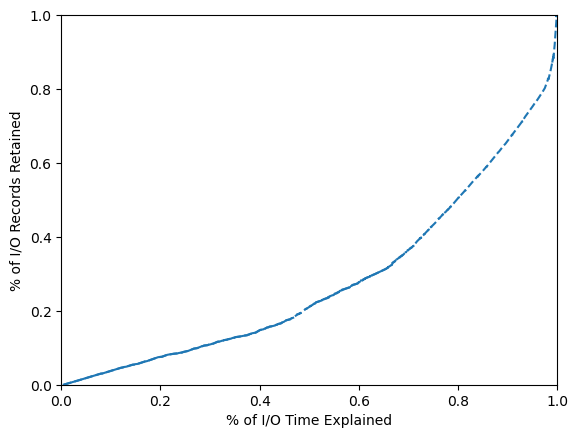

time: 13.9 s (started: 2023-09-24 21:44:23 -07:00)


In [7]:
ax, _ = result.plot.slope(
    metric='duration',
    view_keys=[('time_range',)],
#     ax=ax,
    xlabel='% of I/O Time Explained',
    ylabel='% of I/O Records Retained',
#     color=f"C{i}"
)
ax

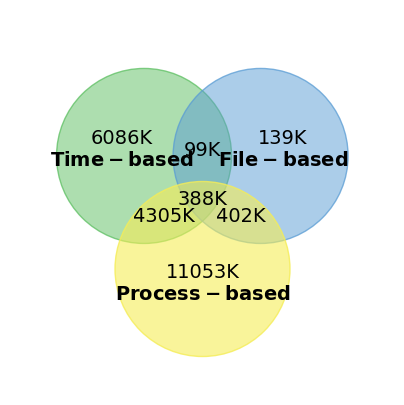

time: 55.6 s (started: 2023-09-25 22:29:15 -07:00)


In [7]:
fig, ax = result.plot.view_relations3(
    metric='duration',
    view_key1=('time_range',),
    view_key2=('file_name',),
    view_key3=('proc_name',),
    label1='Time-based',
    label2='File-based',
    label3='Process-based'
)
ax.get_legend().remove()

In [9]:
for metric in result.bottlenecks:
    for view_type in result.bottlenecks[metric]:
        print(metric, view_type, len(result.bottlenecks[metric][view_type].high_level_view))

duration ('time_range',) 889
duration ('file_name',) 475152
duration ('proc_name',) 857
duration ('time_range', 'file_name') 148139
duration ('time_range', 'proc_name') 1291
duration ('file_name', 'time_range') 1404
duration ('file_name', 'proc_name') 1460
duration ('proc_name', 'time_range') 855
duration ('proc_name', 'file_name') 245494
duration ('time_range', 'file_name', 'proc_name') 1399
duration ('time_range', 'proc_name', 'file_name') 58345
duration ('file_name', 'time_range', 'proc_name') 808
duration ('file_name', 'proc_name', 'time_range') 1060
duration ('proc_name', 'time_range', 'file_name') 61341
duration ('proc_name', 'file_name', 'time_range') 1312
time: 50min 35s (started: 2023-09-26 09:19:42 -07:00)


2023-09-26 10:24:47,061 - distributed.scheduler - ERROR - Error transitioning "('unique-chunk-05c40aef689398fca2a883603d1fed29-bf59accc838eca672e6bcb43c0d14e84', 0)" from 'processing' to 'erred'
Traceback (most recent call last):
  File "/usr/workspace/iopp/anaconda-lassen/envs/wisio_lassen/lib/python3.9/site-packages/distributed/scheduler.py", line 1853, in _transition
    recommendations, client_msgs, worker_msgs = func(
TypeError: transition_processing_erred() missing 1 required keyword-only argument: 'worker'
2023-09-26 10:24:47,099 - distributed.scheduler - ERROR - transition_processing_erred() missing 1 required keyword-only argument: 'worker'
Traceback (most recent call last):
  File "/usr/workspace/iopp/anaconda-lassen/envs/wisio_lassen/lib/python3.9/site-packages/distributed/utils.py", line 742, in wrapper
    return await func(*args, **kwargs)
  File "/usr/workspace/iopp/anaconda-lassen/envs/wisio_lassen/lib/python3.9/site-packages/distributed/scheduler.py", line 4850, in rem

In [8]:
from wisio.rules import Rule
from wisio._recorder.rules import RecorderRuleEngine

rules = dict(
    # app_name=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    # file_dir=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    # file_name=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    # file_regex=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    # node_name=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    # proc_name=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    # rank=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    time_range=[Rule.BOTT_METADATA_ACCESS],
)

rule_engine = RecorderRuleEngine(rules=rules)

rule_engine


time: 81.6 ms (started: 2023-09-25 22:30:20 -07:00)


In [ ]:
%autoreload 2

characteristics = rule_engine.process_characteristics(view=result.main_view)
characteristics


In [ ]:
from rich.console import Console
from rich.panel import Panel
from rich.table import Table
from rich.tree import Tree

# Create a new Table object from Rich library
table = Table(box=None, show_header=False)

# Add columns to the table for the key and value
table.add_column(style="cyan")
table.add_column()

# Add each key-value pair to the table as a row
for rule, result in characteristics.items():
    if result.detail_list is None:
        table.add_row(result.description, result.value_fmt)
    else:
        detail_tree = Tree(result.value_fmt)
        for detail in result.detail_list:
            detail_tree.add(detail)
        table.add_row(result.description, detail_tree)

# Create a Console object from Rich library
console = Console()

# Print the table with Rich formatting
console.print(Panel(table, title='Summary'))
